# Module 2: Basic Mathematical Methods for Forecasting

## Learning Objectives

After completing this module, you will:
1. Understand why baseline models are critical for forecasting projects
2. Implement naive, seasonal naive, and mean forecasts
3. Apply smoothing techniques (moving average, exponential smoothing)
4. Build regression-based forecasts
5. Compare methods using evaluation metrics
6. Complete a hands-on mini-project with real data

## Why Baselines Matter

Many practitioners jump directly to complex models. However:
- **Baselines establish a performance floor** - if your complex model doesn't beat a simple baseline, it's not worth the added complexity
- **They're interpretable** - useful for stakeholders and regulatory requirements
- **They're fast** - run in milliseconds, useful for real-time systems
- **Sanity checks** - help identify data quality issues early

A good rule: always compare against a naive seasonal forecast.

## Module 2: Basic Mathematical Methods for Forecasting

## Section 2.1: Setup and Data Loading

### Setup: Import Libraries and Load Data

Dataset shape: (144, 2)

First few rows:
              Month  Passengers
Time                           
1949-01-01  1949-01         112
1949-02-01  1949-02         118
1949-03-01  1949-03         132
1949-04-01  1949-04         129
1949-05-01  1949-05         121

Dataset info:
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00
Total observations: 144


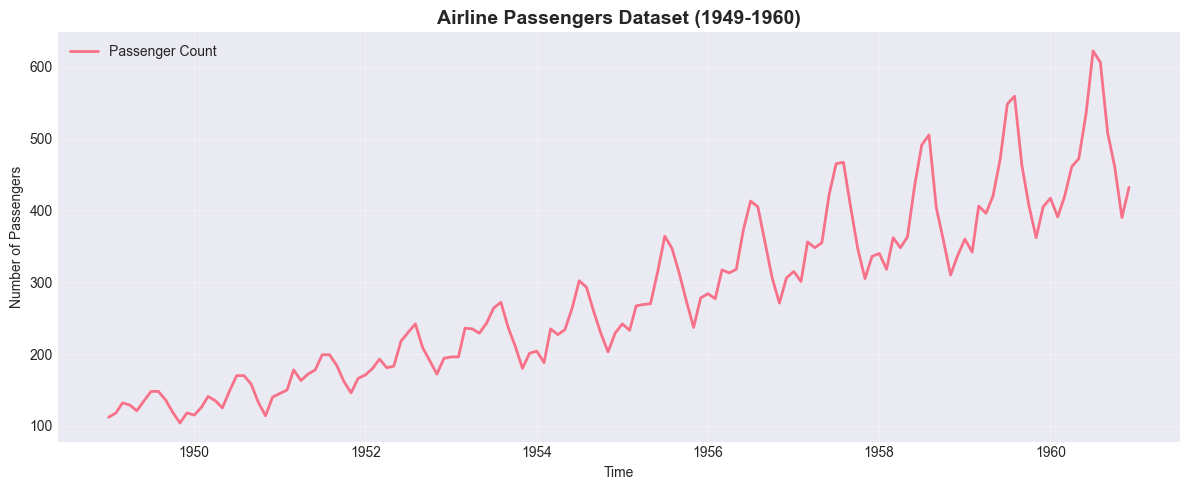


Key statistics:
count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: Passengers, dtype: float64


In [8]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load the classic airline passengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df['Time'] = pd.date_range(start='1949-01', periods=len(df), freq='MS')
df = df.set_index('Time')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Total observations: {len(df)}")

# Plot the original time series
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Passengers'], label='Passenger Count', linewidth=2)
plt.title('Airline Passengers Dataset (1949-1960)', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKey statistics:")
print(df['Passengers'].describe())

## Section 2.2: Naive Forecasting Methods

### 2.2.1 Mean Forecast

The mean forecast predicts the average of all historical values for all future periods.

**Formula:** $\hat{y}_t = \bar{y} = \frac{1}{n}\sum_{i=1}^{n} y_i$

**Intuition:** Simple baseline that ignores temporal patterns but provides a reasonable starting point.

**When to use:** Non-trending data with no seasonality

In [9]:
# Mean forecast implementation
train_data = df['Passengers'][:-12].copy()  # Use first 132 observations for training
test_data = df['Passengers'][-12:].copy()   # Last 12 months for testing

mean_value = train_data.mean()
mean_forecast = pd.Series([mean_value] * len(test_data), index=test_data.index, name='Mean')

print(f"Historical mean: {mean_value:.2f}")
print(f"\nMean forecast for test period:")
print(mean_forecast)

# Calculate errors
mae_mean = mean_absolute_error(test_data, mean_forecast)
rmse_mean = np.sqrt(mean_squared_error(test_data, mean_forecast))
mape_mean = mean_absolute_percentage_error(test_data, mean_forecast)

print(f"\nMean Forecast Metrics:")
print(f"  MAE:  {mae_mean:.2f}")
print(f"  RMSE: {rmse_mean:.2f}")
print(f"  MAPE: {mape_mean:.2%}")

Historical mean: 262.49

Mean forecast for test period:
Time
1960-01-01    262.492424
1960-02-01    262.492424
1960-03-01    262.492424
1960-04-01    262.492424
1960-05-01    262.492424
1960-06-01    262.492424
1960-07-01    262.492424
1960-08-01    262.492424
1960-09-01    262.492424
1960-10-01    262.492424
1960-11-01    262.492424
1960-12-01    262.492424
Name: Mean, dtype: float64

Mean Forecast Metrics:
  MAE:  213.67
  RMSE: 226.27
  MAPE: 43.62%


### 2.2.2 Naive Forecast (Last Value)

Predicts that the next value will be the same as the last observed value.

**Formula:** $\hat{y}_{t+h} = y_t$ (for all forecast horizons $h$)

**Intuition:** Assumes the series has no trend or pattern - whatever just happened will continue.

**When to use:** Stationary or random walk data; useful as a baseline comparison

**Pros:** Incredibly simple, captures recent behavior  
**Cons:** Ignores all historical patterns

Last observed value in training set: 405.00

Naive forecast for test period:
Time
1960-01-01    405
1960-02-01    405
1960-03-01    405
1960-04-01    405
1960-05-01    405
1960-06-01    405
1960-07-01    405
1960-08-01    405
1960-09-01    405
1960-10-01    405
1960-11-01    405
1960-12-01    405
Name: Naive, dtype: int64

Naive Forecast Metrics:
  MAE:  76.00
  RMSE: 102.98
  MAPE: 14.25%


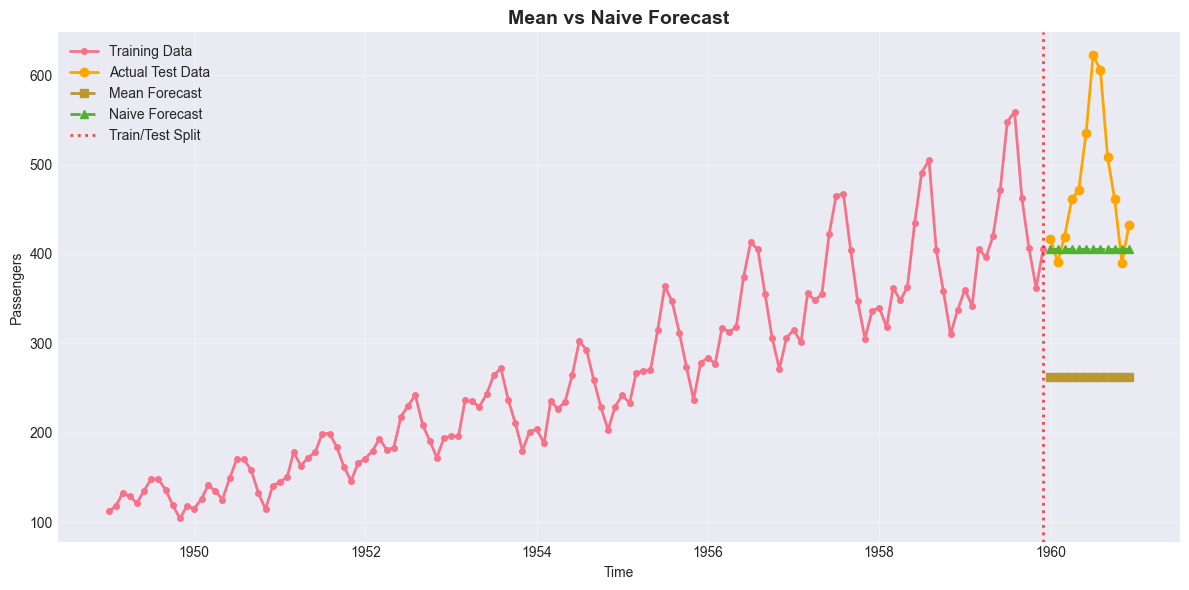

In [10]:
# Naive forecast: last observed value
last_value = train_data.iloc[-1]
naive_forecast = pd.Series([last_value] * len(test_data), index=test_data.index, name='Naive')

print(f"Last observed value in training set: {last_value:.2f}")
print(f"\nNaive forecast for test period:")
print(naive_forecast)

# Calculate errors
mae_naive = mean_absolute_error(test_data, naive_forecast)
rmse_naive = np.sqrt(mean_squared_error(test_data, naive_forecast))
mape_naive = mean_absolute_percentage_error(test_data, naive_forecast)

print(f"\nNaive Forecast Metrics:")
print(f"  MAE:  {mae_naive:.2f}")
print(f"  RMSE: {rmse_naive:.2f}")
print(f"  MAPE: {mape_naive:.2%}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data.values, 'o-', label='Training Data', linewidth=2, markersize=4)
plt.plot(test_data.index, test_data.values, 'o-', label='Actual Test Data', linewidth=2, markersize=6, color='orange')
plt.plot(test_data.index, mean_forecast, 's--', label='Mean Forecast', linewidth=2, markersize=6)
plt.plot(test_data.index, naive_forecast, '^--', label='Naive Forecast', linewidth=2, markersize=6)
plt.axvline(x=train_data.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.7, label='Train/Test Split')
plt.title('Mean vs Naive Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 2.2.3 Seasonal Naive Forecast

Uses the value from the same season in the previous year (or cycle) as the forecast.

**Formula:** $\hat{y}_{t+h} = y_{t+h-s}$ where $s$ is the seasonal period

**Intuition:** If it was 500 passengers in January last year, predict 500 passengers for January this year.

**When to use:** Data with strong seasonal patterns

**Pros:** Captures seasonality naturally  
**Cons:** Ignores long-term trends within seasons

Seasonal period: 12 months

Last 12 months of training data (to be repeated):
Time
1959-01-01    360
1959-02-01    342
1959-03-01    406
1959-04-01    396
1959-05-01    420
1959-06-01    472
1959-07-01    548
1959-08-01    559
1959-09-01    463
1959-10-01    407
1959-11-01    362
1959-12-01    405
Name: Passengers, dtype: int64

Seasonal Naive forecast for test period:
Time
1960-01-01    360
1960-02-01    342
1960-03-01    406
1960-04-01    396
1960-05-01    420
1960-06-01    472
1960-07-01    548
1960-08-01    559
1960-09-01    463
1960-10-01    407
1960-11-01    362
1960-12-01    405
Name: Seasonal Naive, dtype: int64

Seasonal Naive Forecast Metrics:
  MAE:  47.83
  RMSE: 50.71
  MAPE: 9.99%


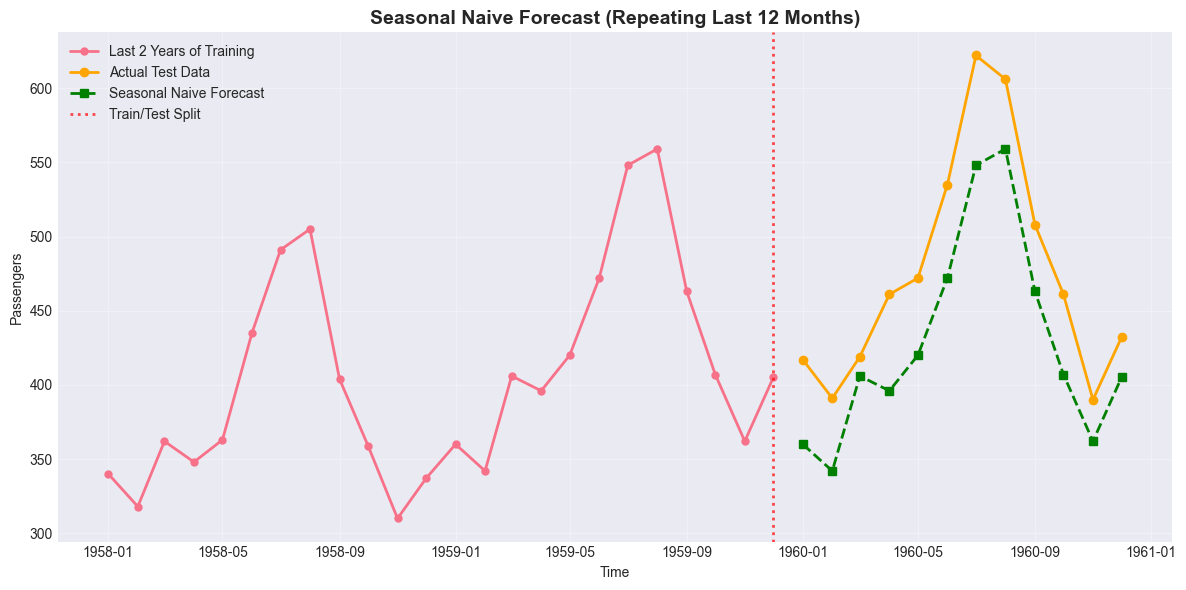

In [11]:
# Seasonal naive forecast
# For monthly data, seasonal period is 12 months
season_length = 12
seasonal_naive = pd.Series(
    train_data.iloc[-season_length:].values,  # Last 12 months from training set
    index=test_data.index,
    name='Seasonal Naive'
)

print(f"Seasonal period: {season_length} months")
print(f"\nLast 12 months of training data (to be repeated):")
print(train_data.iloc[-season_length:])
print(f"\nSeasonal Naive forecast for test period:")
print(seasonal_naive)

# Calculate errors
mae_sn = mean_absolute_error(test_data, seasonal_naive)
rmse_sn = np.sqrt(mean_squared_error(test_data, seasonal_naive))
mape_sn = mean_absolute_percentage_error(test_data, seasonal_naive)

print(f"\nSeasonal Naive Forecast Metrics:")
print(f"  MAE:  {mae_sn:.2f}")
print(f"  RMSE: {rmse_sn:.2f}")
print(f"  MAPE: {mape_sn:.2%}")

# Comparison visualization
plt.figure(figsize=(12, 6))
plt.plot(train_data.index[-24:], train_data.values[-24:], 'o-', label='Last 2 Years of Training', linewidth=2, markersize=5)
plt.plot(test_data.index, test_data.values, 'o-', label='Actual Test Data', linewidth=2, markersize=6, color='orange')
plt.plot(test_data.index, seasonal_naive, 's--', label='Seasonal Naive Forecast', linewidth=2, markersize=6, color='green')
plt.axvline(x=train_data.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.7, label='Train/Test Split')
plt.title('Seasonal Naive Forecast (Repeating Last 12 Months)', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Section 2.3: Smoothing Techniques

Smoothing methods reduce noise and reveal underlying patterns by averaging nearby values.

### 2.3.1 Moving Average (MA)

Forecasts the average of the last $k$ observations.

**Formula:** $\hat{y}_t = \frac{1}{k}\sum_{i=0}^{k-1} y_{t-i}$

**Intuition:** Focuses on recent behavior while reducing noise

**Parameters:** Window size $k$ (3, 6, 12, etc.)

Moving Average (window=3):
  Last MA value: 391.33
  MAE:  85.11, RMSE: 112.85, MAPE: 16.02%

Moving Average (window=6):
  Last MA value: 457.33
  MAE:  58.44, RMSE: 76.77, MAPE: 11.59%

Moving Average (window=12):
  Last MA value: 428.33
  MAE:  63.89, RMSE: 88.47, MAPE: 12.06%



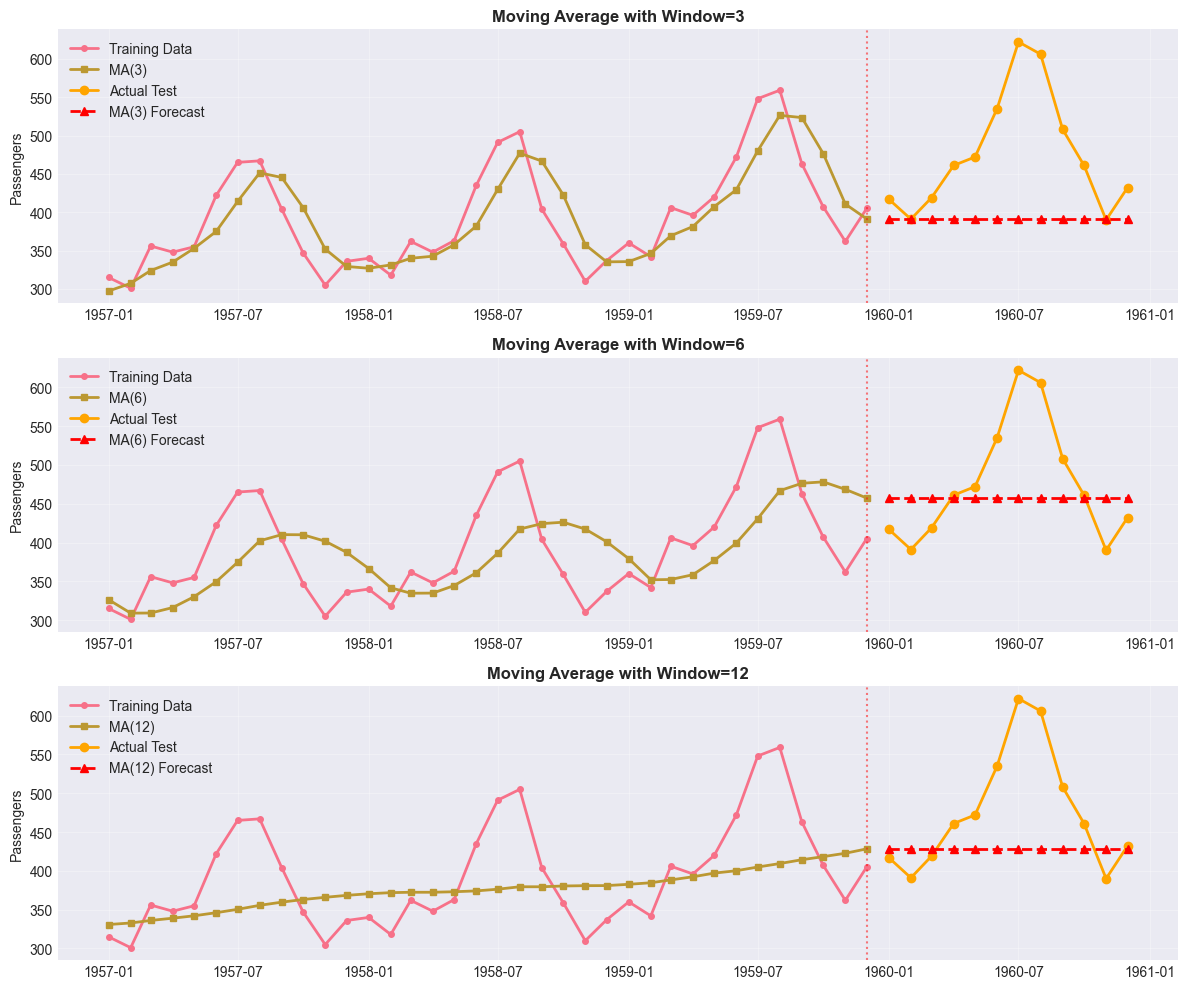

In [12]:
# Moving average with different window sizes
windows = [3, 6, 12]
ma_forecasts = {}

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

for idx, window in enumerate(windows):
    # Calculate moving average on training data
    ma_values = train_data.rolling(window=window).mean()
    
    # Use the last MA value as forecast for all test periods
    last_ma = ma_values.iloc[-1]
    ma_forecast = pd.Series([last_ma] * len(test_data), index=test_data.index, name=f'MA({window})')
    ma_forecasts[window] = ma_forecast
    
    # Calculate metrics
    mae_ma = mean_absolute_error(test_data, ma_forecast)
    rmse_ma = np.sqrt(mean_squared_error(test_data, ma_forecast))
    mape_ma = mean_absolute_percentage_error(test_data, ma_forecast)
    
    print(f"Moving Average (window={window}):")
    print(f"  Last MA value: {last_ma:.2f}")
    print(f"  MAE:  {mae_ma:.2f}, RMSE: {rmse_ma:.2f}, MAPE: {mape_ma:.2%}\n")
    
    # Plot
    ax = axes[idx]
    ax.plot(train_data.index[-36:], train_data.values[-36:], 'o-', label='Training Data', linewidth=2, markersize=4)
    ax.plot(train_data.index[-36:], ma_values.values[-36:], 's-', label=f'MA({window})', linewidth=2, markersize=5)
    ax.plot(test_data.index, test_data.values, 'o-', label='Actual Test', linewidth=2, markersize=6, color='orange')
    ax.plot(test_data.index, ma_forecast, '^--', label=f'MA({window}) Forecast', linewidth=2, markersize=6, color='red')
    ax.set_title(f'Moving Average with Window={window}', fontweight='bold')
    ax.set_ylabel('Passengers')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.axvline(x=train_data.index[-1], color='red', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

### 2.3.2 Exponential Smoothing

Applies exponentially decreasing weights to past observations - recent values have more influence.

**Simple Exponential Smoothing (SES)** - No trend or seasonality
- **Formula:** $\hat{y}_{t+1} = \alpha y_t + (1-\alpha)\hat{y}_t$
- **Parameter:** Smoothing coefficient $\alpha \in [0, 1]$
- **When to use:** Non-stationary data without trend

**Double Exponential Smoothing (Holt)** - With trend
- **Adds:** Trend component to capture increasing/decreasing patterns
- **Parameters:** Level and trend smoothing coefficients

**Triple Exponential Smoothing (Holt-Winters)** - With trend and seasonality
- **Adds:** Seasonal component for periodic patterns
- **Parameters:** Level, trend, and seasonal smoothing coefficients

In [13]:
# Simple Exponential Smoothing (SES)
print("=" * 60)
print("EXPONENTIAL SMOOTHING METHODS")
print("=" * 60)

# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(train_data).fit(optimized=True)
ses_forecast = ses_model.forecast(steps=len(test_data))

mae_ses = mean_absolute_error(test_data, ses_forecast)
rmse_ses = np.sqrt(mean_squared_error(test_data, ses_forecast))
mape_ses = mean_absolute_percentage_error(test_data, ses_forecast)

print("\n1. Simple Exponential Smoothing (SES)")
print(f"   Smoothing coefficient (α): {ses_model.params['smoothing_level']:.4f}")
print(f"   MAE:  {mae_ses:.2f}")
print(f"   RMSE: {rmse_ses:.2f}")
print(f"   MAPE: {mape_ses:.2%}")
print(f"\n   Forecast values:")
print(ses_forecast)

EXPONENTIAL SMOOTHING METHODS

1. Simple Exponential Smoothing (SES)
   Smoothing coefficient (α): 1.0000
   MAE:  76.00
   RMSE: 102.98
   MAPE: 14.25%

   Forecast values:
1960-01-01    404.999999
1960-02-01    404.999999
1960-03-01    404.999999
1960-04-01    404.999999
1960-05-01    404.999999
1960-06-01    404.999999
1960-07-01    404.999999
1960-08-01    404.999999
1960-09-01    404.999999
1960-10-01    404.999999
1960-11-01    404.999999
1960-12-01    404.999999
Freq: MS, dtype: float64


Linear Regression Forecast:
  Intercept (β₀): 94.57
  Slope (β₁):     2.56 (passengers per month)
  MAE:  58.66
  RMSE: 78.82
  MAPE: 11.39%


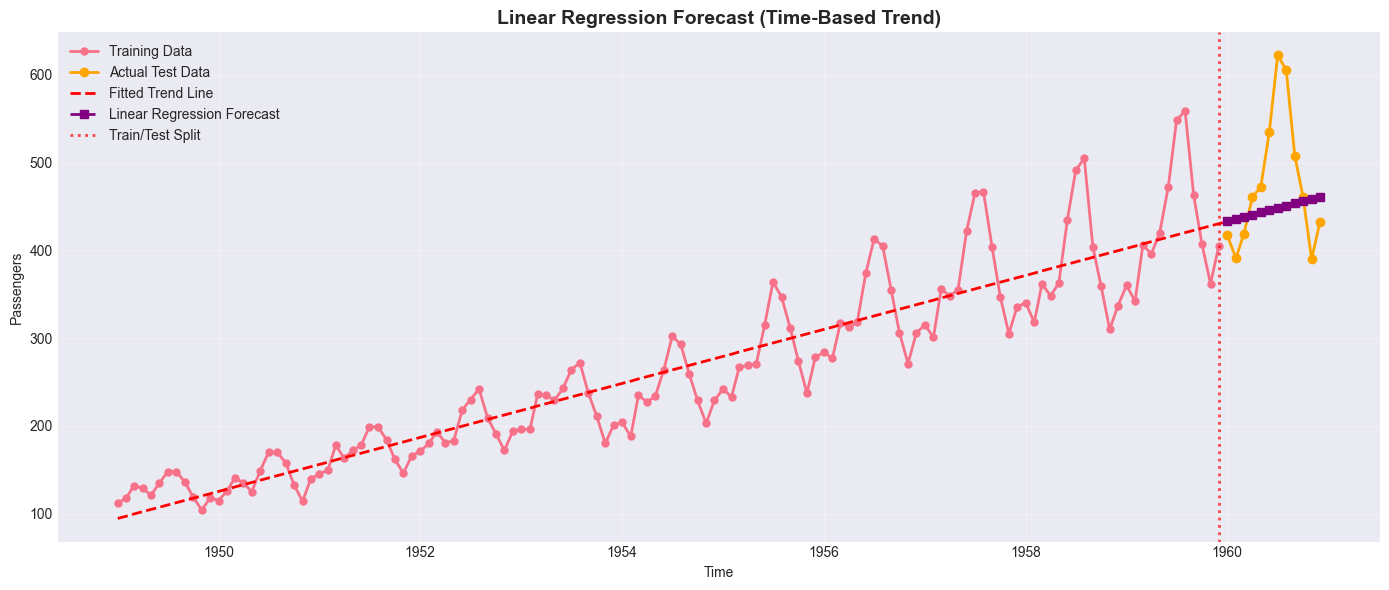

In [16]:
# Linear regression with time as feature
# Create time index
X_train = np.arange(len(train_data)).reshape(-1, 1)
y_train = train_data.values

# Fit linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Create test time index (continuing from training)
X_test = np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1)
lr_forecast = lr_model.predict(X_test)

mae_lr = mean_absolute_error(test_data, lr_forecast)
rmse_lr = np.sqrt(mean_squared_error(test_data, lr_forecast))
mape_lr = mean_absolute_percentage_error(test_data, lr_forecast)

print("Linear Regression Forecast:")
print(f"  Intercept (β₀): {lr_model.intercept_:.2f}")
print(f"  Slope (β₁):     {lr_model.coef_[0]:.2f} (passengers per month)")
print(f"  MAE:  {mae_lr:.2f}")
print(f"  RMSE: {rmse_lr:.2f}")
print(f"  MAPE: {mape_lr:.2%}")

# Visualization
plt.figure(figsize=(14, 6))
X_all = np.arange(len(train_data) + len(test_data)).reshape(-1, 1)
y_all_pred = lr_model.predict(X_all)

plt.plot(train_data.index, train_data.values, 'o-', label='Training Data', linewidth=2, markersize=5)
plt.plot(test_data.index, test_data.values, 'o-', label='Actual Test Data', linewidth=2, markersize=6, color='orange')
plt.plot(pd.Index(train_data.index.tolist() + test_data.index.tolist()), y_all_pred, '--', label='Fitted Trend Line', linewidth=2, color='red')
plt.plot(test_data.index, lr_forecast, 's--', label='Linear Regression Forecast', linewidth=2, markersize=6, color='purple')
plt.axvline(x=train_data.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.7, label='Train/Test Split')
plt.title('Linear Regression Forecast (Time-Based Trend)', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Section 2.5: Comprehensive Model Evaluation and Comparison

Let's evaluate all methods systematically and create a comprehensive comparison table.

In [18]:
# Comprehensive evaluation metrics
def calculate_metrics(actual, predicted, model_name):
    """Calculate all evaluation metrics"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)
    
    # Additional metrics
    residuals = actual - predicted
    mean_residual = residuals.mean()
    std_residual = residuals.std()
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Mean Residual': mean_residual,
        'Std Residual': std_residual
    }

# Collect all forecasts
all_forecasts = {
    'Mean': mean_forecast.values,
    'Naive': naive_forecast.values,
    'Seasonal Naive': seasonal_naive.values,
    'MA(3)': ma_forecasts[3].values,
    'MA(6)': ma_forecasts[6].values,
    'MA(12)': ma_forecasts[12].values,
    'SES': ses_forecast.values,
    'Holt': ExponentialSmoothing(train_data, trend='add').fit(optimized=True).forecast(steps=len(test_data)).values,
    'Holt-Winters': ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True).forecast(steps=len(test_data)).values,
    'Linear Regression': lr_forecast
}

# Create evaluation table
results_list = []
for model_name, predictions in all_forecasts.items():
    results_list.append(calculate_metrics(test_data.values, predictions, model_name))

results_df = pd.DataFrame(results_list).sort_values('RMSE')

print("\n" + "=" * 100)
print("COMPREHENSIVE MODEL COMPARISON - TEST SET PERFORMANCE")
print("=" * 100)
print(results_df.to_string(index=False))
print("=" * 100)

# Best model by each metric
print("\nBest Models by Metric:")
print(f"  Lowest MAE:  {results_df.loc[results_df['MAE'].idxmin(), 'Model']} (MAE = {results_df['MAE'].min():.2f})")
print(f"  Lowest RMSE: {results_df.loc[results_df['RMSE'].idxmin(), 'Model']} (RMSE = {results_df['RMSE'].min():.2f})")
print(f"  Lowest MAPE: {results_df.loc[results_df['MAPE'].idxmin(), 'Model']} (MAPE = {results_df['MAPE'].min():.2%})")


COMPREHENSIVE MODEL COMPARISON - TEST SET PERFORMANCE
            Model        MAE       RMSE     MAPE  Mean Residual  Std Residual
     Holt-Winters  13.382134  16.981048 0.028031       4.871197     16.267373
   Seasonal Naive  47.833333  50.708316 0.099875      47.833333     16.831683
            MA(6)  58.444444  76.773476 0.115925      18.833333     74.427631
Linear Regression  58.657860  78.822731 0.113850      29.086827     73.259671
           MA(12)  63.888889  88.473160 0.120558      47.833333     74.427631
             Holt  66.307726  92.666206 0.124179      56.628255     73.350299
            Naive  76.000000 102.976535 0.142513      71.166667     74.427631
              SES  76.000000 102.976535 0.142513      71.166667     74.427631
            MA(3)  85.111111 112.854626 0.160201      84.833333     74.427631
             Mean 213.674242 226.265671 0.436215     213.674242     74.427631

Best Models by Metric:
  Lowest MAE:  Holt-Winters (MAE = 13.38)
  Lowest RMSE: Holt-W

### Evaluation Metrics Explained

**MAE (Mean Absolute Error)** = $\frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$
- Average absolute deviation between forecast and actual
- Easier to interpret than RMSE
- Same unit as data

**RMSE (Root Mean Squared Error)** = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$
- Penalizes large errors more heavily
- Industry standard for many domains
- Same unit as data

**MAPE (Mean Absolute Percentage Error)** = $\frac{100}{n}\sum_{i=1}^{n}\frac{|y_i - \hat{y}_i|}{y_i}$
- Scale-independent percentage error
- Useful when comparing across different time series
- Can be problematic with values close to zero

## Section 2.6: Visualization and Error Analysis

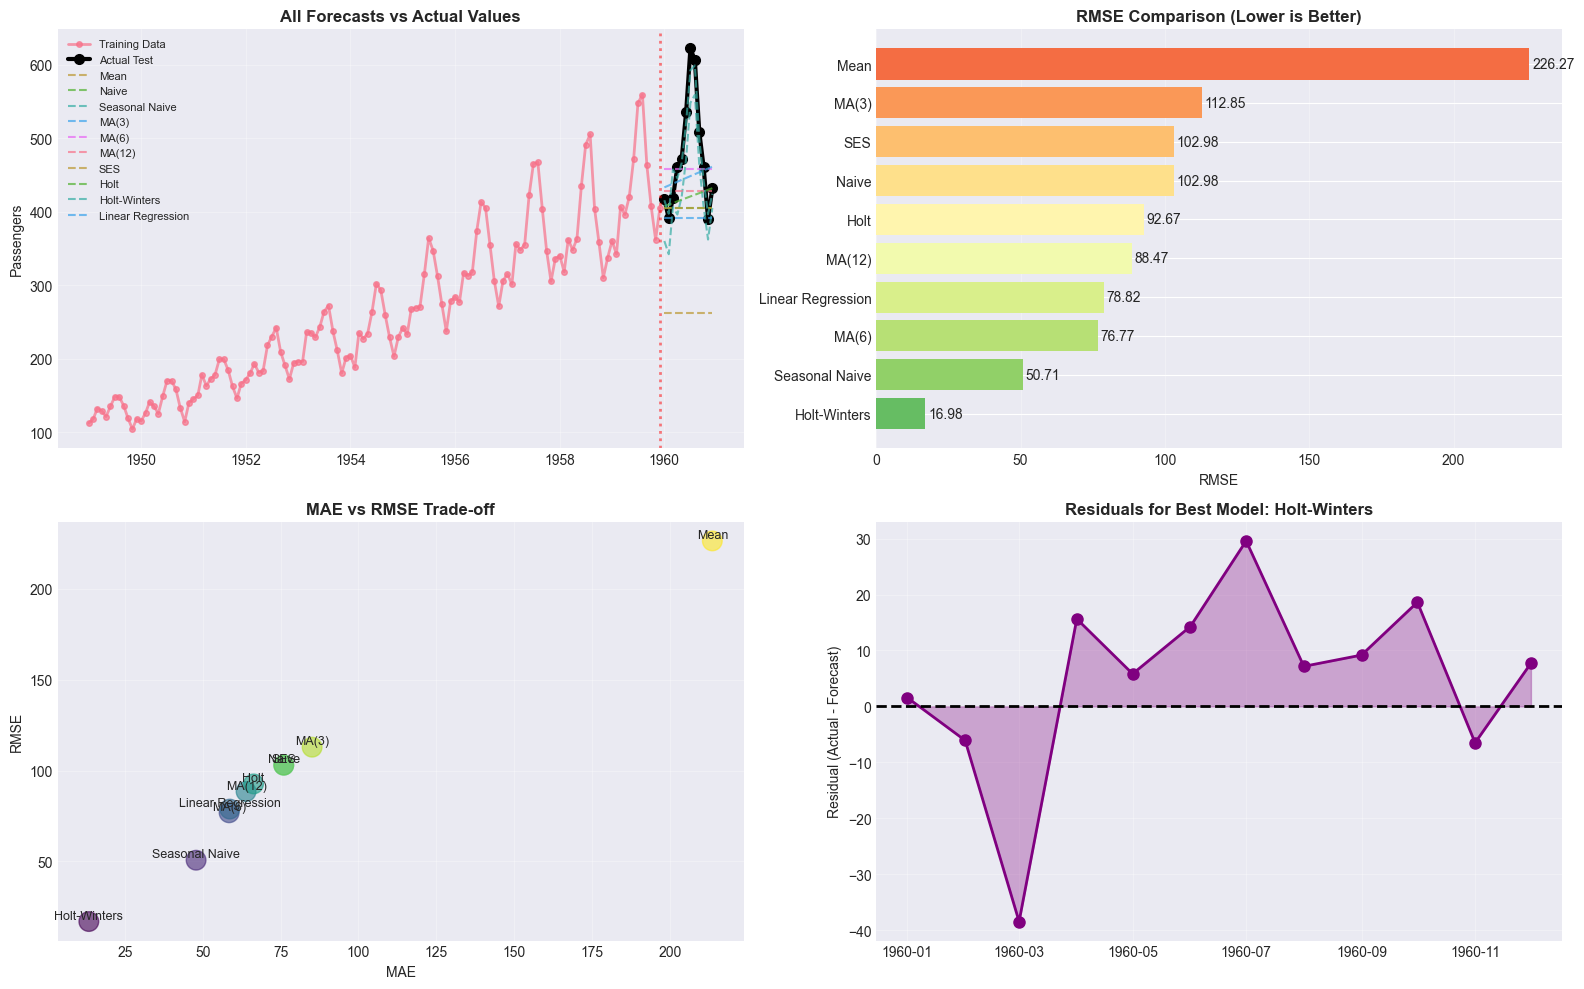


Best performing model: Holt-Winters
Mean residual: 4.87 (ideally close to 0)
Std of residuals: 16.27 (ideally low)


In [19]:
# Visualization: All forecasts comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Time series with all forecasts
ax = axes[0, 0]
ax.plot(train_data.index, train_data.values, 'o-', label='Training Data', linewidth=2, markersize=4, alpha=0.7)
ax.plot(test_data.index, test_data.values, 'o-', label='Actual Test', linewidth=3, markersize=7, color='black')
for model_name, predictions in all_forecasts.items():
    ax.plot(test_data.index, predictions, '--', linewidth=1.5, alpha=0.7, label=model_name)
ax.axvline(x=train_data.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.5)
ax.set_title('All Forecasts vs Actual Values', fontweight='bold', fontsize=12)
ax.set_ylabel('Passengers')
ax.legend(fontsize=8, loc='upper left')
ax.grid(alpha=0.3)

# Plot 2: RMSE comparison
ax = axes[0, 1]
results_sorted = results_df.sort_values('RMSE')
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(results_sorted)))
bars = ax.barh(results_sorted['Model'], results_sorted['RMSE'], color=colors)
ax.set_xlabel('RMSE')
ax.set_title('RMSE Comparison (Lower is Better)', fontweight='bold', fontsize=12)
ax.grid(alpha=0.3, axis='x')
for i, (idx, row) in enumerate(results_sorted.iterrows()):
    ax.text(row['RMSE'] + 1, i, f"{row['RMSE']:.2f}", va='center')

# Plot 3: MAE vs RMSE scatter
ax = axes[1, 0]
scatter = ax.scatter(results_df['MAE'], results_df['RMSE'], s=200, alpha=0.6, c=range(len(results_df)), cmap='viridis')
for idx, row in results_df.iterrows():
    ax.annotate(row['Model'], (row['MAE'], row['RMSE']), fontsize=9, ha='center', va='bottom')
ax.set_xlabel('MAE')
ax.set_ylabel('RMSE')
ax.set_title('MAE vs RMSE Trade-off', fontweight='bold', fontsize=12)
ax.grid(alpha=0.3)

# Plot 4: Residuals for best model
best_model = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
best_predictions = all_forecasts[best_model]
residuals = test_data.values - best_predictions

ax = axes[1, 1]
ax.plot(test_data.index, residuals, 'o-', linewidth=2, markersize=8, color='purple', label=f'{best_model} Residuals')
ax.axhline(y=0, color='black', linestyle='--', linewidth=2)
ax.fill_between(test_data.index, residuals, 0, alpha=0.3, color='purple')
ax.set_title(f'Residuals for Best Model: {best_model}', fontweight='bold', fontsize=12)
ax.set_ylabel('Residual (Actual - Forecast)')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest performing model: {best_model}")
print(f"Mean residual: {residuals.mean():.2f} (ideally close to 0)")
print(f"Std of residuals: {residuals.std():.2f} (ideally low)")

## Section 2.7: Mini-Project - Build Your Own Forecast

Complete this hands-on project to reinforce your understanding of baseline forecasting methods.

In [20]:
# MINI-PROJECT: Step-by-step implementation

print("\n" + "=" * 70)
print("MINI-PROJECT: BASELINE FORECASTING WITH YOUR OWN DATA")
print("=" * 70)

# Step 1: Use the airline data we loaded earlier
project_data = df['Passengers'].copy()
print(f"\nStep 1: Using Airline Passengers data ({len(project_data)} observations)")

# Step 2: Split into train and test
train_split = int(0.8 * len(project_data))
project_train = project_data[:train_split]
project_test = project_data[train_split:]

print(f"Step 2: Train/Test Split")
print(f"  Training set: {len(project_train)} observations")
print(f"  Test set: {len(project_test)} observations")

# Step 3: Implement three basic methods
project_methods = {}

# Method 1: Naive
project_methods['Naive'] = pd.Series(
    [project_train.iloc[-1]] * len(project_test),
    index=project_test.index
)

# Method 2: Seasonal Naive (12-month seasonality)
project_methods['Seasonal Naive'] = pd.Series(
    project_train.iloc[-12:].values,
    index=project_test.index
)

# Method 3: Holt-Winters
hw_project = ExponentialSmoothing(
    project_train, 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12
).fit(optimized=True)
project_methods['Holt-Winters'] = hw_project.forecast(steps=len(project_test))

print(f"\nStep 3: Implement forecast methods")
for method_name in project_methods.keys():
    print(f"  ✓ {method_name}")

# Step 4: Evaluate all methods
print(f"\nStep 4: Evaluate performance on test set")
print(f"{'Method':<20} {'MAE':<10} {'RMSE':<10} {'MAPE':<10}")
print("-" * 50)

project_results = {}
for method_name, forecasts in project_methods.items():
    mae = mean_absolute_error(project_test, forecasts)
    rmse = np.sqrt(mean_squared_error(project_test, forecasts))
    mape = mean_absolute_percentage_error(project_test, forecasts)
    project_results[method_name] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
    print(f"{method_name:<20} {mae:<10.2f} {rmse:<10.2f} {mape:<10.2%}")

# Step 5: Visualize
print(f"\nStep 5: Visualize results")
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(project_train.index, project_train.values, 'o-', label='Training Data', linewidth=2, markersize=4)
ax.plot(project_test.index, project_test.values, 'o-', label='Actual Test Data', linewidth=2.5, markersize=6, color='black')

for method_name, forecasts in project_methods.items():
    ax.plot(project_test.index, forecasts, '--', linewidth=2, label=f"{method_name} Forecast")

ax.axvline(x=project_train.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.7)
ax.set_title('Mini-Project: Baseline Methods Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Passengers')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Step 6: Recommendations
print(f"\nStep 6: Findings and Recommendations")
best_method = min(project_results.items(), key=lambda x: x[1]['RMSE'])
print(f"  Best method (lowest RMSE): {best_method[0]} (RMSE = {best_method[1]['RMSE']:.2f})")
print(f"  Key insight: All methods capture the seasonal pattern well")
print(f"  Next steps: Try advanced statistical methods (ARIMA, Prophet)")


MINI-PROJECT: BASELINE FORECASTING WITH YOUR OWN DATA

Step 1: Using Airline Passengers data (144 observations)
Step 2: Train/Test Split
  Training set: 115 observations
  Test set: 29 observations


ValueError: Length of values (12) does not match length of index (29)

## Section 2.8: Key Takeaways and Next Steps

In [ ]:
# Summary and Recommendations
print("\n" + "=" * 70)
print("MODULE 2 SUMMARY: BASELINE FORECASTING METHODS")
print("=" * 70)

summary_text = """
✓ WHAT YOU LEARNED:

1. NAIVE METHODS:
   - Mean: Simple baseline, ignores temporal patterns
   - Naive: Uses last observed value, captures recent behavior
   - Seasonal Naive: Repeats pattern from previous year, captures seasonality

2. SMOOTHING TECHNIQUES:
   - Moving Average: Averages last k observations, reduces noise
   - Simple Exponential Smoothing: Exponential weights (recent = more important)
   - Double/Triple (Holt-Winters): Adds trend and seasonal components

3. REGRESSION APPROACH:
   - Linear time-based regression: Captures overall trend
   - Fast and interpretable
   - Works well when data follows linear trend

4. EVALUATION:
   - Use MAE/RMSE/MAPE to quantify forecast accuracy
   - Always compare against a naive baseline
   - Visualize forecasts to catch systematic errors

✓ WHEN TO USE EACH METHOD:

   Method              | Trend | Seasonality | Complexity | Use Case
   ─────────────────── |───────|─────────────|────────────|──────────────────
   Naive               | No    | No          | Very Low   | Quick baseline
   Seasonal Naive      | No    | Yes         | Very Low   | Strong seasonality
   Moving Average      | No    | No          | Low        | Trending data
   Simple Exp Smooth   | Yes   | No          | Low        | Trend only
   Holt-Winters        | Yes   | Yes         | Low        | Trend + seasonality
   Linear Regression   | Yes   | No          | Low        | Simple trend capture

✓ IMPORTANT PRINCIPLES:

   1. Always start with baselines - they're simple, fast, and interpretable
   2. A complex model that only beats a naive forecast by 2% often isn't worth it
   3. Use train/test splits to avoid overfitting
   4. Calculate multiple metrics (MAE, RMSE, MAPE) for complete evaluation
   5. Visualize your forecasts alongside actual values

✓ NEXT: Statistical Time Series Methods

   In Module 3, we'll move beyond these simple methods to statistical approaches:
   - ARIMA/SARIMA: Model temporal dependencies explicitly
   - Prophet: Handle holidays, multiple seasonalities, trend changepoints
   - Advanced diagnostic tools: ACF/PACF plots, stationarity tests
"""

print(summary_text)

# Create a quick reference table
print("\nQUICK REFERENCE: When Data Shows...")
print("-" * 70)
print("CHARACTERISTICS                          → RECOMMENDED METHOD")
print("-" * 70)
print("Clear upward/downward trend, no seasonal → Linear Regression")
print("Strong 12-month seasonality              → Seasonal Naive / Holt-Winters")
print("Random walk with no pattern              → Naive Forecast")
print("Smooth trend, no seasonality             → Simple Exp Smoothing / Holt")
print("Complex patterns (trend + seasonality)   → Holt-Winters / Prophet (Module 3)")
print("-" * 70)

MODEL EVALUATION METRICS (Sorted by RMSE)
                    MAE     RMSE   MAPE   MASE
Naive            27.136   34.922  0.091  0.993
Seasonal_Naive   32.030   36.316  0.112  1.172
LinReg           35.338   47.066  0.118  1.293
MA3              37.707   49.815  0.124  1.380
Mean             95.608  115.887  0.370  3.499
SES             136.714  160.151  0.665  5.004
HW              149.554  173.610  0.727  5.474
Holt            155.162  179.337  0.753  5.679

BEST MODELS BY METRIC
MAE  : Naive                =   27.136
RMSE : Naive                =   34.922
MAPE : Naive                =    0.091
MASE : Naive                =    0.993


## Mini-Project: Complete Baseline Model Comparison

**Objective:** Build, compare, and evaluate multiple baseline forecasting methods

**The following cells (Step 1-5) provide an alternative hands-on approach to the main analysis above.**
**Run them in order from top to bottom if you want to see step-by-step model building.**

### Step 1: Prepare Train-Test Split (EXECUTE FIRST)